In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import hijri_converter
from hijri_converter import convert
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import holidays
from datetime import datetime, timedelta
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [2]:
dataset = "D://FrameworkDoRoute//PELNI//revenueDaily.xlsx"
df = pd.read_excel(dataset)
df = df.rename(columns={'tanggal': 'date'})
df = df.rename(columns={'penghasilan_muatan': 'y'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df

,y,date,org,kode_org,des,kode_des
0,115483600.0,2020-11-13,TANJUNG PRIOK,431,PULAU BATAM,256
1,66148880.0,2020-11-17,BELAWAN,144,PULAU BATAM,256
2,455861600.0,2020-11-17,TANJUNG PRIOK,431,AMBON,946
3,121340000.0,2020-11-17,TANJUNG PRIOK,431,AMBON,946
4,161931800.0,2020-11-17,TANJUNG PRIOK,431,BAU-BAU,921
...,...,...,...,...,...,...
21225,21608000.0,2023-04-04,SURABAYA,563,WAINGAPU,685
21226,66820000.0,2023-04-05,AMPENAN/LEMBAR,651,WAINGAPU,685
21227,45776000.0,2023-04-05,BIAK,973,AMBON,946
21228,10000000.0,2023-04-05,BIAK,973,SURABAYA,563


In [3]:
df['route'] = df['kode_org'].astype(str) + '-' + df['kode_des'].astype(str)
label_encoder = LabelEncoder()
df['route_encoded'] = label_encoder.fit_transform(df['route'])

In [4]:
#aggregasi y(revenue/pax) jumlahnya lebih dari satu di (satu tanggal dan rute) yang sama **(optional)
route_df = df.groupby(["org","kode_org","des","kode_des","route_encoded"]).agg({"y": ["sum"]})

# Rename the columns
route_df.columns = ["y"]

# Reset the index
route_df = route_df.reset_index()
route_df

,org,kode_org,des,kode_des,route_encoded,y
0,AGATS,948,BAU-BAU,921,620,1014634.0
1,AGATS,948,KUPANG,681,618,62486.0
2,AGATS,948,MAKASSAR,893,619,1232000.0
3,AGATS,948,MERAUKE,979,621,5570975.0
4,AGATS,948,SURABAYA,563,617,1981000.0
...,...,...,...,...,...,...
861,WASIOR,981,JAYAPURA,974,825,15143480.0
862,WASIOR,981,MAKASSAR,893,822,33962331.0
863,WASIOR,981,SORONG,971,824,7568115.0
864,WASIOR,981,SURABAYA,563,821,1743000.0


In [5]:
## Copy route_df
ds = route_df.copy()
columns_to_scale = ['y']

# Create a scaler object
scaler = StandardScaler()

# Apply feature scaling
ds.loc[:, columns_to_scale] = scaler.fit_transform(ds.loc[:, columns_to_scale])
ds

,org,kode_org,des,kode_des,route_encoded,y
0,AGATS,948,BAU-BAU,921,620,-0.144380
1,AGATS,948,KUPANG,681,618,-0.144587
2,AGATS,948,MAKASSAR,893,619,-0.144333
3,AGATS,948,MERAUKE,979,621,-0.143392
4,AGATS,948,SURABAYA,563,617,-0.144171
...,...,...,...,...,...,...
861,WASIOR,981,JAYAPURA,974,825,-0.141315
862,WASIOR,981,MAKASSAR,893,822,-0.137232
863,WASIOR,981,SORONG,971,824,-0.142958
864,WASIOR,981,SURABAYA,563,821,-0.144222


# Clustering

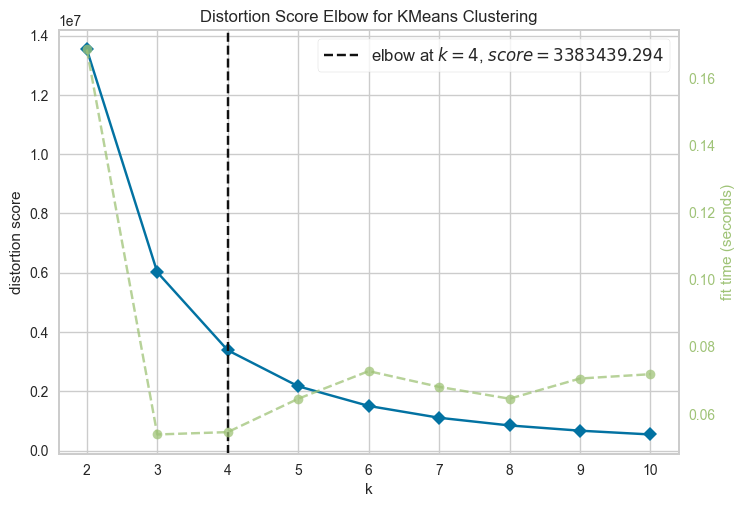

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
## Feature selection for clustering
features = ds[['y','route_encoded']]
## nyari best N
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(features)
Elbow_M.show()

In [7]:
## clustering model + fit]
k=4
AC = AgglomerativeClustering(n_clusters=k)
# fit model and predict clusters
yhat_AC = AC.fit_predict(features)
ds['clusters'] = yhat_AC
route_df['clusters']= yhat_AC

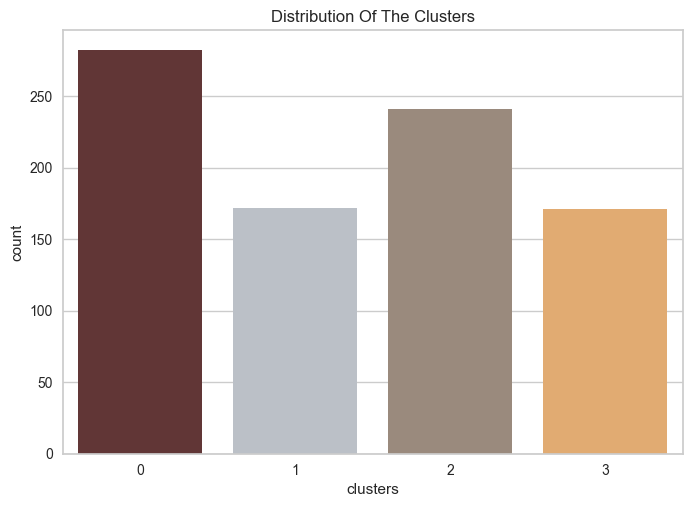

In [8]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=route_df["clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

# Merge Cluster

In [9]:
ts_total = df.groupby(["date","org","kode_org","des","kode_des","route","route_encoded"]).agg({"y":  ["sum"]})

# Rename the columns
ts_total.columns = ["y"]

# Reset the index
ts_total = ts_total.reset_index()
ts_total

,date,org,kode_org,des,kode_des,route,route_encoded,y
0,2020-11-13,TANJUNG PRIOK,431,PULAU BATAM,256,431-256,44,115483600.0
1,2020-11-17,BELAWAN,144,PULAU BATAM,256,144-256,1,66148880.0
2,2020-11-17,TANJUNG PRIOK,431,AMBON,946,431-946,60,577201600.0
3,2020-11-17,TANJUNG PRIOK,431,BAU-BAU,921,431-921,57,165827800.0
4,2020-11-17,TANJUNG PRIOK,431,JAYAPURA,974,431-974,67,578334565.0
...,...,...,...,...,...,...,...,...
19733,2023-04-04,SURABAYA,563,WAINGAPU,685,563-685,89,21608000.0
19734,2023-04-05,AMPENAN/LEMBAR,651,WAINGAPU,685,651-685,147,66820000.0
19735,2023-04-05,BIAK,973,AMBON,946,973-946,731,45776000.0
19736,2023-04-05,BIAK,973,SURABAYA,563,973-563,726,10000000.0


In [10]:
ts_total = ts_total.merge(ds[['route_encoded','clusters']], on=['route_encoded'], how='left')
ts_total = ts_total.sort_values('date')
ts_total

,date,org,kode_org,des,kode_des,route,route_encoded,y,clusters
0,2020-11-13,TANJUNG PRIOK,431,PULAU BATAM,256,431-256,44,115483600.0,3
1,2020-11-17,BELAWAN,144,PULAU BATAM,256,144-256,1,66148880.0,3
2,2020-11-17,TANJUNG PRIOK,431,AMBON,946,431-946,60,577201600.0,3
3,2020-11-17,TANJUNG PRIOK,431,BAU-BAU,921,431-921,57,165827800.0,3
4,2020-11-17,TANJUNG PRIOK,431,JAYAPURA,974,431-974,67,578334565.0,3
...,...,...,...,...,...,...,...,...,...
19733,2023-04-04,SURABAYA,563,WAINGAPU,685,563-685,89,21608000.0,3
19736,2023-04-05,BIAK,973,SURABAYA,563,973-563,726,10000000.0,2
19734,2023-04-05,AMPENAN/LEMBAR,651,WAINGAPU,685,651-685,147,66820000.0,3
19735,2023-04-05,BIAK,973,AMBON,946,973-946,731,45776000.0,2


In [11]:
ts_avg = df.groupby(["date","org","kode_org","des","kode_des","route","route_encoded"]).agg({"y":  ["mean"]})

# Rename the columns
ts_avg.columns = ["y"]

# Reset the index
ts_avg = ts_avg.reset_index()
ts_avg

,date,org,kode_org,des,kode_des,route,route_encoded,y
0,2020-11-13,TANJUNG PRIOK,431,PULAU BATAM,256,431-256,44,115483600.0
1,2020-11-17,BELAWAN,144,PULAU BATAM,256,144-256,1,66148880.0
2,2020-11-17,TANJUNG PRIOK,431,AMBON,946,431-946,60,288600800.0
3,2020-11-17,TANJUNG PRIOK,431,BAU-BAU,921,431-921,57,82913900.0
4,2020-11-17,TANJUNG PRIOK,431,JAYAPURA,974,431-974,67,289167282.5
...,...,...,...,...,...,...,...,...
19733,2023-04-04,SURABAYA,563,WAINGAPU,685,563-685,89,21608000.0
19734,2023-04-05,AMPENAN/LEMBAR,651,WAINGAPU,685,651-685,147,66820000.0
19735,2023-04-05,BIAK,973,AMBON,946,973-946,731,45776000.0
19736,2023-04-05,BIAK,973,SURABAYA,563,973-563,726,10000000.0


In [12]:
ts_avg = ts_avg.merge(ds[['route_encoded','clusters']], on=['route_encoded'], how='left')
ts_avg = ts_avg.sort_values('date')
ts_avg

,date,org,kode_org,des,kode_des,route,route_encoded,y,clusters
0,2020-11-13,TANJUNG PRIOK,431,PULAU BATAM,256,431-256,44,115483600.0,3
1,2020-11-17,BELAWAN,144,PULAU BATAM,256,144-256,1,66148880.0,3
2,2020-11-17,TANJUNG PRIOK,431,AMBON,946,431-946,60,288600800.0,3
3,2020-11-17,TANJUNG PRIOK,431,BAU-BAU,921,431-921,57,82913900.0,3
4,2020-11-17,TANJUNG PRIOK,431,JAYAPURA,974,431-974,67,289167282.5,3
...,...,...,...,...,...,...,...,...,...
19733,2023-04-04,SURABAYA,563,WAINGAPU,685,563-685,89,21608000.0,3
19736,2023-04-05,BIAK,973,SURABAYA,563,973-563,726,10000000.0,2
19734,2023-04-05,AMPENAN/LEMBAR,651,WAINGAPU,685,651-685,147,66820000.0,3
19735,2023-04-05,BIAK,973,AMBON,946,973-946,731,45776000.0,2


# Distance Dataframe

In [13]:
df_port_passanger = pd.read_excel('C://Users//khali//Downloads//output.xlsx')

port_set = set(route_df['kode_org'].unique())
port_list = list(port_set)

for kode_des in route_df['kode_des'].unique():
    if kode_des not in port_set:
#         print(kode_des)
        port_list.append(kode_des)
# len(port_list)
set_pname = []
for code in port_list:
#     print("port code :",code)
    for org in df[['org', 'kode_org']].drop_duplicates().values:
        if code == org[1]:
#             print(org[0])
            set_pname.append(org[0])
    for des in df[['des', 'kode_des']].drop_duplicates().values:
        if code == des[1] and des[0] not in set_pname:
#             print(des[0])
            set_pname.append(des[0])
# len(set_pname)
port_list = [[code, name] for code, name in zip(port_list, set_pname)]
df_port_cargo = pd.DataFrame(port_list, columns=['code', 'name'])

def determine_cargo_reg(row):
    if row[0] in df_port_passanger['code'].values:
        return(df_port_passanger.loc[df_port_passanger['code']==row[0]]['region'].values[0])
    else: 
        return('nan')
    
df_port_cargo['region'] = df_port_cargo.apply(determine_cargo_reg, axis=1)
df_port_cargo

#step 1 kelar
df_port_cargo.loc[df_port_cargo['code'] == 464, 'region'] = 0
df_port_cargo

,code,name,region
0,256,PULAU BATAM,0
1,898,BONTANG,1
2,773,BATULICIN,1
3,266,TANJUNG BALAI KARIMUN,0
4,651,AMPENAN/LEMBAR,1
...,...,...,...
66,956,KISAR,2
67,959,MOA,2
68,958,TEPA,2
69,696,ROTE,1


In [14]:
#perkondisian buat isi kolom is_long, kolom cluster distancenya

def determine_long_route(row):
    if df_port_cargo.loc[df_port_cargo['code'] == row['kode_org'], 'region'].values[0] == df_port_cargo.loc[df_port_cargo['code'] == row['kode_des'], 'region'].values[0]:
        return 0
    else:
        return 1

# Holiday Dataframe

In [15]:
## dataframe hari libur
id_holidays = holidays.ID(years=range(min(df.date.dt.year), max(df.date.dt.year)+1))

data = []

for day, event in id_holidays.items():
    data.append({'day': day, 'event': event})
    
df_holidays = pd.DataFrame(data)
df_holidays['day'] = pd.to_datetime(df_holidays['day'], format='%Y/%m/%d')

#cuti idul fitri
index = df_holidays.loc[df_holidays['event']=="Hari Raya Idul Fitri"].index
original_date = df_holidays.loc[index, 'day']
for date in original_date.values:
    date = pd.to_datetime(date)
#     print(date)
    for i in range(1, 4):
#         print(i)
        date_before = date - timedelta(days=i)
#         print(date_before)
        new_row = {'event': 'Cuti Hari Raya Idul Fitri', 'day': date_before}
#         print(new_row)
        df_holidays = pd.concat([df_holidays, pd.DataFrame([new_row])], ignore_index=True)

index = df_holidays.loc[df_holidays['event']=="Hari kedua dari Hari Raya Idul Fitri"].index
original_date = df_holidays.loc[index, 'day']
for date in original_date.values:
    date = pd.to_datetime(date)
#     print(date)
    for i in range(1, 3):
#         print(i)
        date_after = date + timedelta(days=i)
#         print(date_before)
        new_row = {'event': 'Cuti Hari Raya Idul Fitri', 'day': date_after}
#         print(new_row)
        df_holidays = pd.concat([df_holidays, pd.DataFrame([new_row])])

# Create Features

In [16]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['Is_Mon'] = (df['date'].dt.dayofweek == 0) *1
    df['Is_Tue'] = (df['date'].dt.dayofweek == 1) *1
    df['Is_Wed'] = (df['date'].dt.dayofweek == 2) *1
    df['Is_Thu'] = (df['date'].dt.dayofweek == 3) *1
    df['Is_Fri'] = (df['date'].dt.dayofweek == 4) *1
    df['Is_Sat'] = (df['date'].dt.dayofweek == 5) *1
    df['Is_Sun'] = (df['date'].dt.dayofweek == 6) *1
    df['Is_wknd'] = df['date'].dt.dayofweek // 4 # Fri-Sun are 4-6, Monday is 0 so this is valid
    
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['is_holiday']=df['date'].apply(lambda x: 1 if x in df_holidays['day'].values else 0)
    df['is_covid'] = ((df['date'] >= '2020-03-01') & (df['date'] <= '2021-12-31')).astype(int)
    
    df['Hijri_Year'] = df['date'].apply(lambda x: hijri_converter.Gregorian(x.year, x.month, x.day).to_hijri().year)
    df['Hijri_Month'] = df['date'].apply(lambda x: hijri_converter.Gregorian(x.year, x.month, x.day).to_hijri().month)
    df['Hijri_Day'] =df['date'].apply(lambda x: hijri_converter.Gregorian(x.year, x.month, x.day).to_hijri().day)
    df['is_long'] = df.apply(determine_long_route, axis=1)
    
    return df
ts_total = create_features(ts_total)
ts_total.head()

,date,org,kode_org,des,kode_des,route,route_encoded,y,clusters,Is_Mon,...,year,dayofyear,dayofmonth,weekofyear,is_holiday,is_covid,Hijri_Year,Hijri_Month,Hijri_Day,is_long
0,2020-11-13,TANJUNG PRIOK,431,PULAU BATAM,256,431-256,44,115483600.0,3,0,...,2020,318,13,46,0,1,1442,3,27,0
1,2020-11-17,BELAWAN,144,PULAU BATAM,256,144-256,1,66148880.0,3,0,...,2020,322,17,47,0,1,1442,4,2,0
2,2020-11-17,TANJUNG PRIOK,431,AMBON,946,431-946,60,577201600.0,3,0,...,2020,322,17,47,0,1,1442,4,2,1
3,2020-11-17,TANJUNG PRIOK,431,BAU-BAU,921,431-921,57,165827800.0,3,0,...,2020,322,17,47,0,1,1442,4,2,1
4,2020-11-17,TANJUNG PRIOK,431,JAYAPURA,974,431-974,67,578334565.0,3,0,...,2020,322,17,47,0,1,1442,4,2,1


In [17]:
ts_avg = create_features(ts_avg)
ts_avg.head()

,date,org,kode_org,des,kode_des,route,route_encoded,y,clusters,Is_Mon,...,year,dayofyear,dayofmonth,weekofyear,is_holiday,is_covid,Hijri_Year,Hijri_Month,Hijri_Day,is_long
0,2020-11-13,TANJUNG PRIOK,431,PULAU BATAM,256,431-256,44,115483600.0,3,0,...,2020,318,13,46,0,1,1442,3,27,0
1,2020-11-17,BELAWAN,144,PULAU BATAM,256,144-256,1,66148880.0,3,0,...,2020,322,17,47,0,1,1442,4,2,0
2,2020-11-17,TANJUNG PRIOK,431,AMBON,946,431-946,60,288600800.0,3,0,...,2020,322,17,47,0,1,1442,4,2,1
3,2020-11-17,TANJUNG PRIOK,431,BAU-BAU,921,431-921,57,82913900.0,3,0,...,2020,322,17,47,0,1,1442,4,2,1
4,2020-11-17,TANJUNG PRIOK,431,JAYAPURA,974,431-974,67,289167282.5,3,0,...,2020,322,17,47,0,1,1442,4,2,1


# Add Lags Based on Voyage

In [18]:
def add_lags(ts):
    ts.set_index('date', inplace=True)
    target_map = ts['y'].to_dict()
    ts['lag1'] = (ts.index - pd.Timedelta('7 days')).map(target_map)
    ts['lag2'] = (ts.index - pd.Timedelta('14 days')).map(target_map)
    ts['lag3'] = (ts.index - pd.Timedelta('28 days')).map(target_map)
    ts.reset_index(inplace=True)
    return ts
ts_total = add_lags(ts_total)
ts_total.tail()

,date,org,kode_org,des,kode_des,route,route_encoded,y,clusters,Is_Mon,...,weekofyear,is_holiday,is_covid,Hijri_Year,Hijri_Month,Hijri_Day,is_long,lag1,lag2,lag3
19733,2023-04-04,SURABAYA,563,WAINGAPU,685,563-685,89,21608000.0,3,0,...,14,0,0,1444,9,13,1,295580.0,40412.0,27896000.0
19734,2023-04-05,BIAK,973,SURABAYA,563,973-563,726,10000000.0,2,0,...,14,0,0,1444,9,14,1,798533.0,36186425.0,5096380.0
19735,2023-04-05,AMPENAN/LEMBAR,651,WAINGAPU,685,651-685,147,66820000.0,3,0,...,14,0,0,1444,9,14,0,798533.0,36186425.0,5096380.0
19736,2023-04-05,BIAK,973,AMBON,946,973-946,731,45776000.0,2,0,...,14,0,0,1444,9,14,0,798533.0,36186425.0,5096380.0
19737,2023-04-09,AMBON,946,TANJUNG PRIOK,431,946-431,580,1510000.0,0,0,...,14,0,0,1444,9,18,1,68894000.0,8725561.0,1666497.0


In [19]:
ts_avg = add_lags(ts_avg)
ts_avg.tail()

,date,org,kode_org,des,kode_des,route,route_encoded,y,clusters,Is_Mon,...,weekofyear,is_holiday,is_covid,Hijri_Year,Hijri_Month,Hijri_Day,is_long,lag1,lag2,lag3
19733,2023-04-04,SURABAYA,563,WAINGAPU,685,563-685,89,21608000.0,3,0,...,14,0,0,1444,9,13,1,295580.0,40412.0,27896000.0
19734,2023-04-05,BIAK,973,SURABAYA,563,973-563,726,10000000.0,2,0,...,14,0,0,1444,9,14,1,798533.0,36186425.0,5096380.0
19735,2023-04-05,AMPENAN/LEMBAR,651,WAINGAPU,685,651-685,147,66820000.0,3,0,...,14,0,0,1444,9,14,0,798533.0,36186425.0,5096380.0
19736,2023-04-05,BIAK,973,AMBON,946,973-946,731,45776000.0,2,0,...,14,0,0,1444,9,14,0,798533.0,36186425.0,5096380.0
19737,2023-04-09,AMBON,946,TANJUNG PRIOK,431,946-431,580,1510000.0,0,0,...,14,0,0,1444,9,18,1,68894000.0,4362780.5,1666497.0


In [20]:
ts_total_1= ts_total.loc[ts_total.clusters == 0]
print(min(ts_total_1.y),"-",max(ts_total_1.y))
print(len(ts_total_1))
ts_total_1.head()

2000.0 - 380200000.0
6854


,date,org,kode_org,des,kode_des,route,route_encoded,y,clusters,Is_Mon,...,weekofyear,is_holiday,is_covid,Hijri_Year,Hijri_Month,Hijri_Day,is_long,lag1,lag2,lag3
15,2020-11-20,MAKASSAR,893,SERUI,975,893-975,452,71768000.0,0,0,...,47,0,1,1442,4,5,1,115483600.0,NaN,NaN
16,2020-11-20,MAKASSAR,893,SORONG,971,893-971,448,37436000.0,0,0,...,47,0,1,1442,4,5,1,115483600.0,NaN,NaN
17,2020-11-20,MAKASSAR,893,AMBON,946,893-946,442,24488000.0,0,0,...,47,0,1,1442,4,5,1,115483600.0,NaN,NaN
18,2020-11-20,MAKASSAR,893,JAYAPURA,974,893-974,451,28298000.0,0,0,...,47,0,1,1442,4,5,1,115483600.0,NaN,NaN
19,2020-11-21,BAU-BAU,921,AMBON,946,921-946,491,9458000.0,0,0,...,47,0,1,1442,4,6,1,NaN,NaN,NaN


In [21]:
ts_avg_1= ts_avg.loc[ts_avg.clusters == 0]
print(min(ts_avg_1.y),"-",max(ts_avg_1.y))
print(len(ts_total_1))
ts_avg_1.head()

2000.0 - 380200000.0
6854


,date,org,kode_org,des,kode_des,route,route_encoded,y,clusters,Is_Mon,...,weekofyear,is_holiday,is_covid,Hijri_Year,Hijri_Month,Hijri_Day,is_long,lag1,lag2,lag3
15,2020-11-20,MAKASSAR,893,SERUI,975,893-975,452,71768000.0,0,0,...,47,0,1,1442,4,5,1,115483600.0,NaN,NaN
16,2020-11-20,MAKASSAR,893,SORONG,971,893-971,448,37436000.0,0,0,...,47,0,1,1442,4,5,1,115483600.0,NaN,NaN
17,2020-11-20,MAKASSAR,893,AMBON,946,893-946,442,12244000.0,0,0,...,47,0,1,1442,4,5,1,115483600.0,NaN,NaN
18,2020-11-20,MAKASSAR,893,JAYAPURA,974,893-974,451,28298000.0,0,0,...,47,0,1,1442,4,5,1,115483600.0,NaN,NaN
19,2020-11-21,BAU-BAU,921,AMBON,946,921-946,491,9458000.0,0,0,...,47,0,1,1442,4,6,1,NaN,NaN,NaN


# Remove Outliers

In [22]:
def remove_outliers(df, column, threshold=3.5):
    median = df[column].median()
    mad = np.median(np.abs(df[column] - median))
    threshold_value = threshold * mad
    #upper bound = med+tv 
    #lower bound = med-tv
    upper_bound = median+threshold_value
    lower_bound = (median - threshold_value) 
    print("median :",(median))
    print("MAD :",mad)
    print("TV :",threshold_value)
    print("upper bound :",upper_bound)
    print("lower bound :",lower_bound)

    outliers = df[(abs(df[column]) > upper_bound) | (abs(df[column]) < lower_bound)]
    print("jumlah :",len(outliers), outliers)
    filtered_df = df.drop(outliers.index)

    return filtered_df

In [23]:
ts_total_1 = remove_outliers(ts_total_1, 'y', threshold=1)
print(min(ts_total_1.y),"-",max(ts_total_1.y))
ts_total_1

median : 2400000.0
MAD : 2035500.0
TV : 2035500.0
upper bound : 4435500.0
lower bound : 364500.0
jumlah : 3427             date       org  kode_org            des  kode_des    route   
15    2020-11-20  MAKASSAR       893          SERUI       975  893-975  \
16    2020-11-20  MAKASSAR       893         SORONG       971  893-971   
17    2020-11-20  MAKASSAR       893          AMBON       946  893-946   
18    2020-11-20  MAKASSAR       893       JAYAPURA       974  893-974   
19    2020-11-21   BAU-BAU       921          AMBON       946  921-946   
...          ...       ...       ...            ...       ...      ...   
19714 2023-03-31   BONTANG       898      PARE-PARE       892  898-892   
19722 2023-04-01  MAKASSAR       893         SORONG       971  893-971   
19723 2023-04-01  MAKASSAR       893          SERUI       975  893-975   
19725 2023-04-01   BAU-BAU       921  TANJUNG PRIOK       431  921-431   
19730 2023-04-03  MAKASSAR       893       JAYAPURA       974  893-974   



,date,org,kode_org,des,kode_des,route,route_encoded,y,clusters,Is_Mon,...,weekofyear,is_holiday,is_covid,Hijri_Year,Hijri_Month,Hijri_Day,is_long,lag1,lag2,lag3
23,2020-11-22,AMBON,946,SERUI,975,946-975,606,603000.0,0,0,...,47,0,1,1442,4,7,0,NaN,NaN,NaN
24,2020-11-22,AMBON,946,SORONG,971,946-971,602,667000.0,0,0,...,47,0,1,1442,4,7,0,NaN,NaN,NaN
65,2020-12-06,BAU-BAU,921,SORONG,971,921-971,495,813000.0,0,0,...,49,0,1,1442,4,21,1,31336000.0,667000.0,NaN
91,2020-12-14,AMBON,946,BAU-BAU,921,946-921,588,504000.0,0,1,...,51,0,1,1442,4,29,1,NaN,9152000.0,NaN
93,2020-12-14,AMBON,946,SURABAYA,563,946-563,581,923000.0,0,1,...,51,0,1,1442,4,29,1,NaN,9152000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19707,2023-03-30,AGATS,948,MERAUKE,979,948-979,621,1094912.0,0,0,...,13,0,0,1444,9,8,0,3735791.0,48019398.0,672731.0
19715,2023-03-31,AMBON,946,BIAK,973,946-973,604,740000.0,0,0,...,13,0,0,1444,9,9,0,143811061.0,886819.0,1500000.0
19724,2023-04-01,MAKASSAR,893,AMBON,946,893-946,442,706000.0,0,0,...,13,0,0,1444,9,10,1,19745153.0,1620000.0,3618394.0
19728,2023-04-02,MAKASSAR,893,BENOA/DENPASAR,613,893-613,419,509085.0,0,0,...,13,0,0,1444,9,11,0,8725561.0,7303092.0,1023378.0


In [24]:
ts_avg_1 = remove_outliers(ts_avg_1, 'y', threshold=1)
print(min(ts_avg_1.y),"-",max(ts_avg_1.y))
ts_avg_1

median : 2277000.0
MAD : 1917500.0
TV : 1917500.0
upper bound : 4194500.0
lower bound : 359500.0
jumlah : 3426             date       org  kode_org            des  kode_des    route   
15    2020-11-20  MAKASSAR       893          SERUI       975  893-975  \
16    2020-11-20  MAKASSAR       893         SORONG       971  893-971   
17    2020-11-20  MAKASSAR       893          AMBON       946  893-946   
18    2020-11-20  MAKASSAR       893       JAYAPURA       974  893-974   
19    2020-11-21   BAU-BAU       921          AMBON       946  921-946   
...          ...       ...       ...            ...       ...      ...   
19714 2023-03-31   BONTANG       898      PARE-PARE       892  898-892   
19722 2023-04-01  MAKASSAR       893         SORONG       971  893-971   
19723 2023-04-01  MAKASSAR       893          SERUI       975  893-975   
19725 2023-04-01   BAU-BAU       921  TANJUNG PRIOK       431  921-431   
19730 2023-04-03  MAKASSAR       893       JAYAPURA       974  893-974   



,date,org,kode_org,des,kode_des,route,route_encoded,y,clusters,Is_Mon,...,weekofyear,is_holiday,is_covid,Hijri_Year,Hijri_Month,Hijri_Day,is_long,lag1,lag2,lag3
23,2020-11-22,AMBON,946,SERUI,975,946-975,606,603000.0,0,0,...,47,0,1,1442,4,7,0,NaN,NaN,NaN
24,2020-11-22,AMBON,946,SORONG,971,946-971,602,667000.0,0,0,...,47,0,1,1442,4,7,0,NaN,NaN,NaN
65,2020-12-06,BAU-BAU,921,SORONG,971,921-971,495,813000.0,0,0,...,49,0,1,1442,4,21,1,3.133600e+07,667000.0,NaN
91,2020-12-14,AMBON,946,BAU-BAU,921,946-921,588,504000.0,0,1,...,51,0,1,1442,4,29,1,NaN,4576000.0,NaN
93,2020-12-14,AMBON,946,SURABAYA,563,946-563,581,923000.0,0,1,...,51,0,1,1442,4,29,1,NaN,4576000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19707,2023-03-30,AGATS,948,MERAUKE,979,948-979,621,1094912.0,0,0,...,13,0,0,1444,9,8,0,3.735791e+06,48019398.0,672731.0
19715,2023-03-31,AMBON,946,BIAK,973,946-973,604,740000.0,0,0,...,13,0,0,1444,9,9,0,4.793702e+07,886819.0,1500000.0
19724,2023-04-01,MAKASSAR,893,AMBON,946,893-946,442,706000.0,0,0,...,13,0,0,1444,9,10,1,1.974515e+07,1620000.0,3618394.0
19728,2023-04-02,MAKASSAR,893,BENOA/DENPASAR,613,893-613,419,509085.0,0,0,...,13,0,0,1444,9,11,0,4.362780e+06,7303092.0,1023378.0


In [25]:
ts_total_1[['org','kode_org','des','kode_des']].value_counts()

org        kode_org  des             kode_des
MAKASSAR   893       AMBON           946         89
                     TARAKAN         808         86
                     SURABAYA        563         80
AMBON      946       DOBO            944         79
BAU-BAU    921       AMBON           946         70
                                                 ..
GORONTALO  841       BIMA            655          1
                     BENOA/DENPASAR  613          1
AGATS      948       MAKASSAR        893          1
DOBO       944       WANCI           923          1
GORONTALO  841       BAU-BAU         921          1
Name: count, Length: 251, dtype: int64

In [26]:
ts_avg_1[['org','kode_org','des','kode_des']].value_counts()

org        kode_org  des        kode_des
MAKASSAR   893       AMBON      946         90
                     TARAKAN    808         87
                     SURABAYA   563         83
AMBON      946       DOBO       944         77
BAU-BAU    921       AMBON      946         73
                                            ..
PANTOLOAN  863       LARANTUKA  687          1
DOBO       944       NAMROLE    929          1
                     SAUMLAKI   950          1
NAMROLE    929       WANCI      923          1
AGATS      948       BAU-BAU    921          1
Name: count, Length: 251, dtype: int64

In [27]:
ts_avg_1

,date,org,kode_org,des,kode_des,route,route_encoded,y,clusters,Is_Mon,...,weekofyear,is_holiday,is_covid,Hijri_Year,Hijri_Month,Hijri_Day,is_long,lag1,lag2,lag3
23,2020-11-22,AMBON,946,SERUI,975,946-975,606,603000.0,0,0,...,47,0,1,1442,4,7,0,NaN,NaN,NaN
24,2020-11-22,AMBON,946,SORONG,971,946-971,602,667000.0,0,0,...,47,0,1,1442,4,7,0,NaN,NaN,NaN
65,2020-12-06,BAU-BAU,921,SORONG,971,921-971,495,813000.0,0,0,...,49,0,1,1442,4,21,1,3.133600e+07,667000.0,NaN
91,2020-12-14,AMBON,946,BAU-BAU,921,946-921,588,504000.0,0,1,...,51,0,1,1442,4,29,1,NaN,4576000.0,NaN
93,2020-12-14,AMBON,946,SURABAYA,563,946-563,581,923000.0,0,1,...,51,0,1,1442,4,29,1,NaN,4576000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19707,2023-03-30,AGATS,948,MERAUKE,979,948-979,621,1094912.0,0,0,...,13,0,0,1444,9,8,0,3.735791e+06,48019398.0,672731.0
19715,2023-03-31,AMBON,946,BIAK,973,946-973,604,740000.0,0,0,...,13,0,0,1444,9,9,0,4.793702e+07,886819.0,1500000.0
19724,2023-04-01,MAKASSAR,893,AMBON,946,893-946,442,706000.0,0,0,...,13,0,0,1444,9,10,1,1.974515e+07,1620000.0,3618394.0
19728,2023-04-02,MAKASSAR,893,BENOA/DENPASAR,613,893-613,419,509085.0,0,0,...,13,0,0,1444,9,11,0,4.362780e+06,7303092.0,1023378.0


In [28]:
ts_total_1

,date,org,kode_org,des,kode_des,route,route_encoded,y,clusters,Is_Mon,...,weekofyear,is_holiday,is_covid,Hijri_Year,Hijri_Month,Hijri_Day,is_long,lag1,lag2,lag3
23,2020-11-22,AMBON,946,SERUI,975,946-975,606,603000.0,0,0,...,47,0,1,1442,4,7,0,NaN,NaN,NaN
24,2020-11-22,AMBON,946,SORONG,971,946-971,602,667000.0,0,0,...,47,0,1,1442,4,7,0,NaN,NaN,NaN
65,2020-12-06,BAU-BAU,921,SORONG,971,921-971,495,813000.0,0,0,...,49,0,1,1442,4,21,1,31336000.0,667000.0,NaN
91,2020-12-14,AMBON,946,BAU-BAU,921,946-921,588,504000.0,0,1,...,51,0,1,1442,4,29,1,NaN,9152000.0,NaN
93,2020-12-14,AMBON,946,SURABAYA,563,946-563,581,923000.0,0,1,...,51,0,1,1442,4,29,1,NaN,9152000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19707,2023-03-30,AGATS,948,MERAUKE,979,948-979,621,1094912.0,0,0,...,13,0,0,1444,9,8,0,3735791.0,48019398.0,672731.0
19715,2023-03-31,AMBON,946,BIAK,973,946-973,604,740000.0,0,0,...,13,0,0,1444,9,9,0,143811061.0,886819.0,1500000.0
19724,2023-04-01,MAKASSAR,893,AMBON,946,893-946,442,706000.0,0,0,...,13,0,0,1444,9,10,1,19745153.0,1620000.0,3618394.0
19728,2023-04-02,MAKASSAR,893,BENOA/DENPASAR,613,893-613,419,509085.0,0,0,...,13,0,0,1444,9,11,0,8725561.0,7303092.0,1023378.0


In [29]:
features = ['kode_org','kode_des','clusters','is_long','is_holiday','is_covid','year','month','dayofweek','dayofmonth','dayofyear','Is_Mon','Is_Tue','Is_Wed','Is_Thu','Is_Fri','Is_Sat','Is_Sun','Hijri_Year','Hijri_Month','Hijri_Day','lag1','lag2','lag3']
label = ['y']

# FEATURE SCALING (ts_total_1)

In [30]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dropout, TimeDistributed,BatchNormalization, Dense
from keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from keras import regularizers


scaler = MinMaxScaler(feature_range=(0, 1))
numeric_columns = ['lag1','lag2','lag3']


# Apply the scaler to both training and test features
ts_total_1[numeric_columns] = scaler.fit_transform(ts_total_1[numeric_columns])
ts_total_1 = ts_total_1.fillna(0)
ts_total_1

,date,org,kode_org,des,kode_des,route,route_encoded,y,clusters,Is_Mon,...,weekofyear,is_holiday,is_covid,Hijri_Year,Hijri_Month,Hijri_Day,is_long,lag1,lag2,lag3
23,2020-11-22,AMBON,946,SERUI,975,946-975,606,603000.0,0,0,...,47,0,1,1442,4,7,0,0.000000,0.000000,0.000000
24,2020-11-22,AMBON,946,SORONG,971,946-971,602,667000.0,0,0,...,47,0,1,1442,4,7,0,0.000000,0.000000,0.000000
65,2020-12-06,BAU-BAU,921,SORONG,971,921-971,495,813000.0,0,0,...,49,0,1,1442,4,21,1,0.113895,0.002419,0.000000
91,2020-12-14,AMBON,946,BAU-BAU,921,946-921,588,504000.0,0,1,...,51,0,1,1442,4,29,1,0.000000,0.033260,0.000000
93,2020-12-14,AMBON,946,SURABAYA,563,946-563,581,923000.0,0,1,...,51,0,1,1442,4,29,1,0.000000,0.033260,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19707,2023-03-30,AGATS,948,MERAUKE,979,948-979,621,1094912.0,0,0,...,13,0,0,1444,9,8,0,0.013573,0.174536,0.002439
19715,2023-03-31,AMBON,946,BIAK,973,946-973,604,740000.0,0,0,...,13,0,0,1444,9,9,0,0.522721,0.003218,0.005446
19724,2023-04-01,MAKASSAR,893,AMBON,946,893-946,442,706000.0,0,0,...,13,0,0,1444,9,10,1,0.071764,0.005883,0.013146
19728,2023-04-02,MAKASSAR,893,BENOA/DENPASAR,613,893-613,419,509085.0,0,0,...,13,0,0,1444,9,11,0,0.031710,0.026540,0.003714


# Test Exclude 5 Test Route (ts_total_1)

In [31]:
X_train = ts_total_1[features]
y_train = ts_total_1[label]

data_test = ts_total_1.loc[(ts_total_1['kode_org'] == 893)&(ts_total_1['kode_des'] == 974)&(ts_total_1.date>='2023-01-01')]
X_test  = data_test[features]
y_test  = data_test[label]

#exclude data test
test_indices = X_test.index
X_train = X_train.drop(test_indices)
test_indices = y_test.index
y_train = y_train.drop(test_indices)

data_test = ts_total_1.loc[(ts_total_1['kode_org'] == 893)&(ts_total_1['kode_des'] == 946)&(ts_total_1.date>='2023-01-01')]
X_test  = data_test[features]
y_test  = data_test[label]

#exclude data test
test_indices = X_test.index
X_train = X_train.drop(test_indices)
test_indices = y_test.index
y_train = y_train.drop(test_indices)

data_test = ts_total_1.loc[(ts_total_1['kode_org'] == 893)&(ts_total_1['kode_des'] == 563)&(ts_total_1.date>='2023-01-01')]
X_test  = data_test[features]
y_test  = data_test[label]

#exclude data test
test_indices = X_test.index
X_train = X_train.drop(test_indices)
test_indices = y_test.index
y_train = y_train.drop(test_indices)

print('X_train   :',X_train.shape)
print('X_test   :',X_test.shape)
print('y_train   :',y_train.shape)
print('y_test   :',y_test.shape)

X_train   : (3403, 24)
X_test   : (7, 24)
y_train   : (3403, 1)
y_test   : (7, 1)


# BIKIN MODEL LSTM

In [32]:
n_steps = 1
n_features = X_train.shape[1]
print('Panjang features :',n_features)

# Build the LSTM model
model = Sequential()
model.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(256, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1))

# Compile the model
optimizer = RMSprop(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Prepare data for training and validation
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print('X_train   :',X_train.shape)
print('y_train :',y_train.shape)
print('X_test :',X_test.shape)
print('y_test :',y_test.shape)

# Reshape input data to match the LSTM layer's input shape
X_train = X_train.reshape((X_train.shape[0], n_steps, n_features))
y_train = y_train.reshape((y_train.shape[0], n_steps, 1))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_features))
y_test = y_test.reshape((y_test.shape[0], n_steps, 1))

print('X_train reshaped:',X_train.shape)
print('y_train reshaped:',y_train.shape)
print('X_test reshaped:',X_test.shape)
print('y_test reshaped:',y_test.shape)

Panjang features : 24
X_train   : (3403, 24)
y_train : (3403, 1)
X_test : (7, 24)
y_test : (7, 1)
X_train reshaped: (3403, 1, 24)
y_train reshaped: (3403, 1, 1)
X_test reshaped: (7, 1, 24)
y_test reshaped: (7, 1, 1)


In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 512)            1099776   
                                                                 
 dropout (Dropout)           (None, 1, 512)            0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8

# TRAIN MODEL

In [34]:
# Train the model with validation data
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
54/54 [==============================] - 5s 42ms/step - loss: 2838518300672.0000 - val_loss: 1135200043008.0000
Epoch 2/100
54/54 [==============================] - 2s 31ms/step - loss: 1310849892352.0000 - val_loss: 1222949076992.0000
Epoch 3/100
54/54 [==============================] - 2s 31ms/step - loss: 1271218700288.0000 - val_loss: 1199545516032.0000
Epoch 4/100
54/54 [==============================] - 2s 33ms/step - loss: 1277325737984.0000 - val_loss: 1287108296704.0000
Epoch 5/100
54/54 [==============================] - 2s 31ms/step - loss: 1279801950208.0000 - val_loss: 1185347272704.0000
Epoch 6/100
54/54 [==============================] - 2s 31ms/step - loss: 1272351424512.0000 - val_loss: 1201611210752.0000
Epoch 7/100
54/54 [==============================] - 2s 31ms/step - loss: 1277268066304.0000 - val_loss: 1187541811200.0000
Epoch 8/100
54/54 [==============================] - 2s 33ms/step - loss: 1288547467264.0000 - val_loss: 1254524059648.0000
Epoch 9/

# EVALUATE MODEL

X_test reshaped: (3, 1, 24)
y_test reshaped: (3, 1, 1)
1/1 [==============================] - 0s 26ms/step
Train RMSE: 1047198.6912408432
Test RMSE: 716913.883990932
Train MAE: 792671.5709300617
Test MAE: 655181.875
Train R-squared: -0.06207599200785596
Test R-squared: -4.916170871122084


<Axes: xlabel='date'>

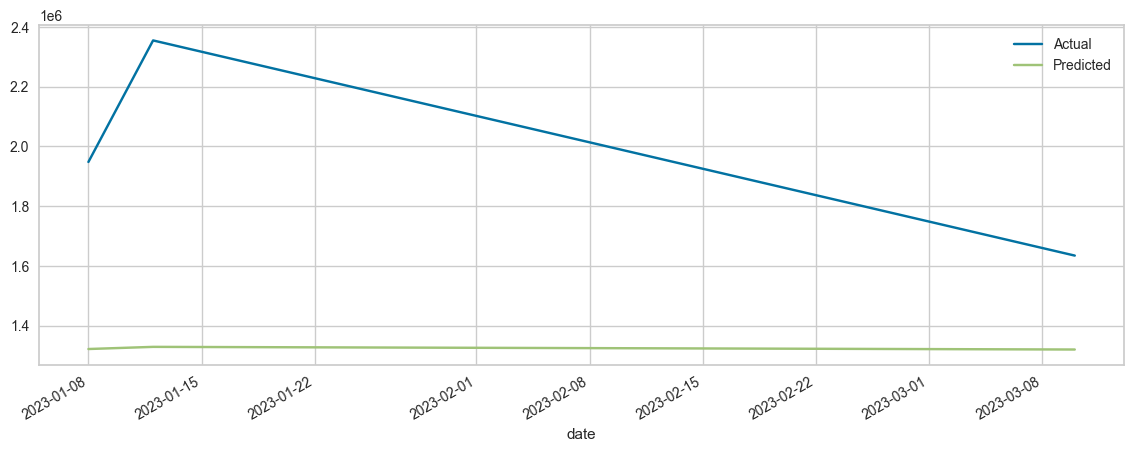

In [35]:
data_test = ts_total_1.loc[(ts_total_1['kode_org'] == 893)&(ts_total_1['kode_des'] == 974)&(ts_total_1.date>='2023-01-01')]
X_test  = data_test[features]
y_test  = data_test[label]

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape((X_test.shape[0], n_steps, n_features))
y_test = y_test.reshape((y_test.shape[0], n_steps, 1))

print('X_test reshaped:',X_test.shape)
print('y_test reshaped:',y_test.shape)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Flatten the actual and predicted values
y_train_actual = y_train.flatten()
y_test_actual = y_test.flatten()
y_train_pred = y_train_pred.flatten()
y_test_pred = y_test_pred.flatten()

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

# Calculate MAE
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)

# Calculate R-squared
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

# Print the results
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Train MAE:', train_mae)
print('Test MAE:', test_mae)
print('Train R-squared:', train_r2)
print('Test R-squared:', test_r2)
df_results = pd.DataFrame({'Actual': y_test_actual, 'Predicted': y_test_pred,'date':data_test.date})
df_results.set_index('date', inplace=True)
df_results.plot(figsize=(14,5))

X_test reshaped: (14, 1, 24)
y_test reshaped: (14, 1, 1)
1/1 [==============================] - 0s 25ms/step
Train RMSE: 1047198.6912408432
Test RMSE: 1272246.0949241864
Train MAE: 792671.5709300617
Test MAE: 1007953.2857142857
Train R-squared: -0.06207599200785596
Test R-squared: -0.5388192822774616


<Axes: xlabel='date'>

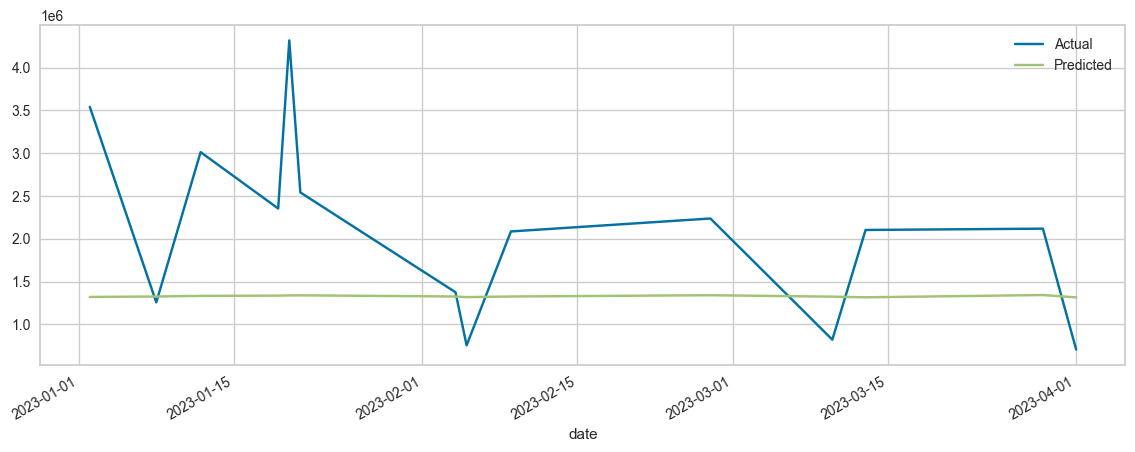

In [36]:
data_test = ts_total_1.loc[(ts_total_1['kode_org'] == 893)&(ts_total_1['kode_des'] == 946)&(ts_total_1.date>='2023-01-01')]
X_test  = data_test[features]
y_test  = data_test[label]

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape((X_test.shape[0], n_steps, n_features))
y_test = y_test.reshape((y_test.shape[0], n_steps, 1))

print('X_test reshaped:',X_test.shape)
print('y_test reshaped:',y_test.shape)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Flatten the actual and predicted values
y_train_actual = y_train.flatten()
y_test_actual = y_test.flatten()
y_train_pred = y_train_pred.flatten()
y_test_pred = y_test_pred.flatten()

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

# Calculate MAE
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)

# Calculate R-squared
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

# Print the results
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Train MAE:', train_mae)
print('Test MAE:', test_mae)
print('Train R-squared:', train_r2)
print('Test R-squared:', test_r2)
df_results = pd.DataFrame({'Actual': y_test_actual, 'Predicted': y_test_pred,'date':data_test.date})
df_results.set_index('date', inplace=True)
df_results.plot(figsize=(14,5))

X_test reshaped: (7, 1, 24)
y_test reshaped: (7, 1, 1)
1/1 [==============================] - 0s 35ms/step
Train RMSE: 1047198.6912408432
Test RMSE: 1105469.122564757
Train MAE: 792671.5709300617
Test MAE: 933452.6785714285
Train R-squared: -0.06207599200785596
Test R-squared: -0.08502160586205232


<Axes: xlabel='date'>

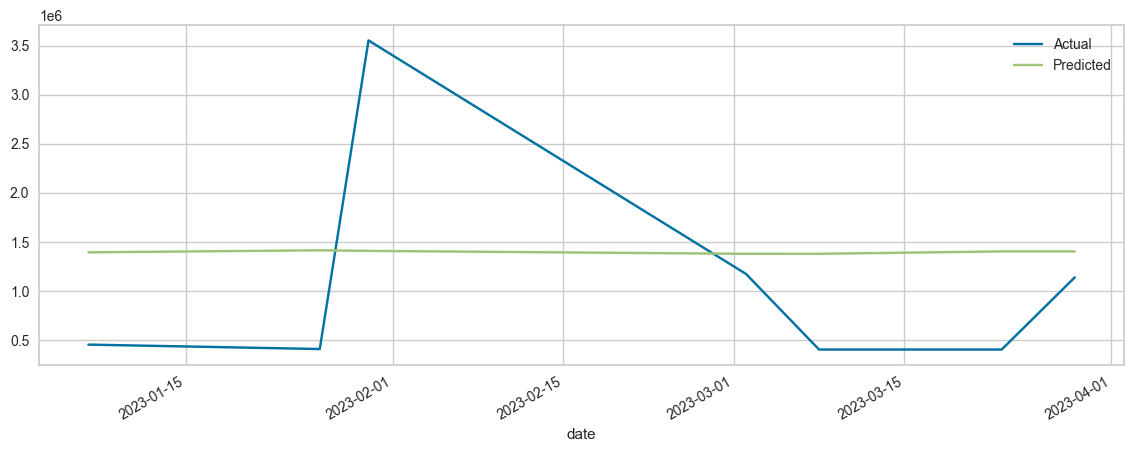

In [37]:
data_test = ts_total_1.loc[(ts_total_1['kode_org'] == 893)&(ts_total_1['kode_des'] == 563)&(ts_total_1.date>='2023-01-01')]
X_test  = data_test[features]
y_test  = data_test[label]

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape((X_test.shape[0], n_steps, n_features))
y_test = y_test.reshape((y_test.shape[0], n_steps, 1))

print('X_test reshaped:',X_test.shape)
print('y_test reshaped:',y_test.shape)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Flatten the actual and predicted values
y_train_actual = y_train.flatten()
y_test_actual = y_test.flatten()
y_train_pred = y_train_pred.flatten()
y_test_pred = y_test_pred.flatten()

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

# Calculate MAE
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)

# Calculate R-squared
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

# Print the results
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Train MAE:', train_mae)
print('Test MAE:', test_mae)
print('Train R-squared:', train_r2)
print('Test R-squared:', test_r2)
df_results = pd.DataFrame({'Actual': y_test_actual, 'Predicted': y_test_pred,'date':data_test.date})
df_results.set_index('date', inplace=True)
df_results.plot(figsize=(14,5))

# FEATURE SCALING (ts_avg_1)

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
numeric_columns = ['lag1','lag2','lag3']


# Apply the scaler to both training and test features
ts_avg_1[numeric_columns] = scaler.fit_transform(ts_avg_1[numeric_columns])
ts_avg_1 = ts_avg_1.fillna(0)
ts_avg_1

,date,org,kode_org,des,kode_des,route,route_encoded,y,clusters,Is_Mon,...,weekofyear,is_holiday,is_covid,Hijri_Year,Hijri_Month,Hijri_Day,is_long,lag1,lag2,lag3
23,2020-11-22,AMBON,946,SERUI,975,946-975,606,603000.0,0,0,...,47,0,1,1442,4,7,0,0.000000,0.000000,0.000000
24,2020-11-22,AMBON,946,SORONG,971,946-971,602,667000.0,0,0,...,47,0,1,1442,4,7,0,0.000000,0.000000,0.000000
65,2020-12-06,BAU-BAU,921,SORONG,971,921-971,495,813000.0,0,0,...,49,0,1,1442,4,21,1,0.113895,0.002419,0.000000
91,2020-12-14,AMBON,946,BAU-BAU,921,946-921,588,504000.0,0,1,...,51,0,1,1442,4,29,1,0.000000,0.016627,0.000000
93,2020-12-14,AMBON,946,SURABAYA,563,946-563,581,923000.0,0,1,...,51,0,1,1442,4,29,1,0.000000,0.016627,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19707,2023-03-30,AGATS,948,MERAUKE,979,948-979,621,1094912.0,0,0,...,13,0,0,1444,9,8,0,0.013573,0.174536,0.002439
19715,2023-03-31,AMBON,946,BIAK,973,946-973,604,740000.0,0,0,...,13,0,0,1444,9,9,0,0.174236,0.003218,0.005446
19724,2023-04-01,MAKASSAR,893,AMBON,946,893-946,442,706000.0,0,0,...,13,0,0,1444,9,10,1,0.071764,0.005883,0.013146
19728,2023-04-02,MAKASSAR,893,BENOA/DENPASAR,613,893-613,419,509085.0,0,0,...,13,0,0,1444,9,11,0,0.015852,0.026540,0.003714


# Test Exclude 5 Test Route (ts_avg_1)

In [39]:
X_train = ts_avg_1[features]
y_train = ts_avg_1[label]

data_test = ts_avg_1.loc[(ts_avg_1['kode_org'] == 893)&(ts_avg_1['kode_des'] == 974)&(ts_avg_1.date>='2023-01-01')]
X_test  = data_test[features]
y_test  = data_test[label]

#exclude data test
test_indices = X_test.index
X_train = X_train.drop(test_indices)
test_indices = y_test.index
y_train = y_train.drop(test_indices)

data_test = ts_avg_1.loc[(ts_avg_1['kode_org'] == 893)&(ts_avg_1['kode_des'] == 946)&(ts_avg_1.date>='2023-01-01')]
X_test  = data_test[features]
y_test  = data_test[label]

#exclude data test
test_indices = X_test.index
X_train = X_train.drop(test_indices)
test_indices = y_test.index
y_train = y_train.drop(test_indices)

data_test = ts_avg_1.loc[(ts_avg_1['kode_org'] == 893)&(ts_avg_1['kode_des'] == 563)&(ts_avg_1.date>='2023-01-01')]
X_test  = data_test[features]
y_test  = data_test[label]

#exclude data test
test_indices = X_test.index
X_train = X_train.drop(test_indices)
test_indices = y_test.index
y_train = y_train.drop(test_indices)

print('X_train   :',X_train.shape)
print('X_test   :',X_test.shape)
print('y_train   :',y_train.shape)
print('y_test   :',y_test.shape)

X_train   : (3404, 24)
X_test   : (7, 24)
y_train   : (3404, 1)
y_test   : (7, 1)


# BIKIN MODEL LSTM

In [40]:
n_steps = 1
n_features = X_train.shape[1]
print('Panjang features :',n_features)

# Build the LSTM model
model = Sequential()
model.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(256, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1))

# Compile the model
optimizer = RMSprop(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Prepare data for training and validation
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print('X_train   :',X_train.shape)
print('y_train :',y_train.shape)
print('X_test :',X_test.shape)
print('y_test :',y_test.shape)

# Reshape input data to match the LSTM layer's input shape
X_train = X_train.reshape((X_train.shape[0], n_steps, n_features))
y_train = y_train.reshape((y_train.shape[0], n_steps, 1))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_features))
y_test = y_test.reshape((y_test.shape[0], n_steps, 1))

print('X_train reshaped:',X_train.shape)
print('y_train reshaped:',y_train.shape)
print('X_test reshaped:',X_test.shape)
print('y_test reshaped:',y_test.shape)

Panjang features : 24
X_train   : (3404, 24)
y_train : (3404, 1)
X_test : (7, 24)
y_test : (7, 1)
X_train reshaped: (3404, 1, 24)
y_train reshaped: (3404, 1, 1)
X_test reshaped: (7, 1, 24)
y_test reshaped: (7, 1, 1)


In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 512)            1099776   
                                                                 
 dropout_4 (Dropout)         (None, 1, 512)            0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)               

# TRAIN MODEL

In [42]:
# Train the model with validation data
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
54/54 [==============================] - 7s 52ms/step - loss: 2331614117888.0000 - val_loss: 1173111046144.0000
Epoch 2/100
54/54 [==============================] - 2s 35ms/step - loss: 1140385906688.0000 - val_loss: 1208697487360.0000
Epoch 3/100
54/54 [==============================] - 2s 38ms/step - loss: 1126906724352.0000 - val_loss: 1190017368064.0000
Epoch 4/100
54/54 [==============================] - 2s 35ms/step - loss: 1113508151296.0000 - val_loss: 1146413645824.0000
Epoch 5/100
54/54 [==============================] - 2s 36ms/step - loss: 1142546628608.0000 - val_loss: 1201750671360.0000
Epoch 6/100
54/54 [==============================] - 2s 37ms/step - loss: 1111826759680.0000 - val_loss: 1171286786048.0000
Epoch 7/100
54/54 [==============================] - 2s 35ms/step - loss: 1082676740096.0000 - val_loss: 1158805585920.0000
Epoch 8/100
54/54 [==============================] - 2s 33ms/step - loss: 1119158272000.0000 - val_loss: 1149523722240.0000
Epoch 9/

# EVALUATE MODEL

X_test reshaped: (3, 1, 24)
y_test reshaped: (3, 1, 1)
1/1 [==============================] - 0s 38ms/step
Train RMSE: 955621.9937520926
Test RMSE: 676985.7355293335
Train MAE: 746589.1450009792
Test MAE: 611320.2083333334
Train R-squared: -0.01684195083474993
Test R-squared: -4.275525934957158


<Axes: xlabel='date'>

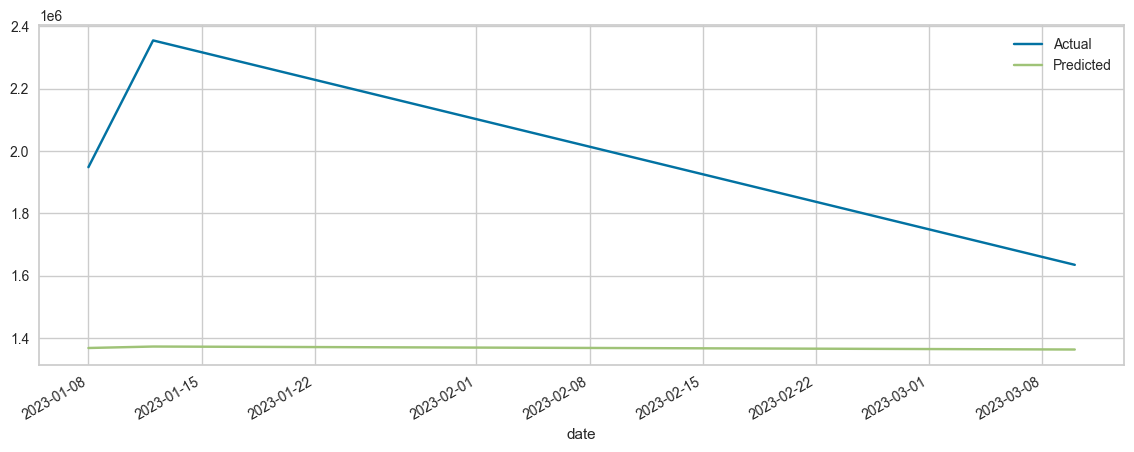

In [43]:
data_test = ts_total_1.loc[(ts_total_1['kode_org'] == 893)&(ts_total_1['kode_des'] == 974)&(ts_total_1.date>='2023-01-01')]
X_test  = data_test[features]
y_test  = data_test[label]

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape((X_test.shape[0], n_steps, n_features))
y_test = y_test.reshape((y_test.shape[0], n_steps, 1))

print('X_test reshaped:',X_test.shape)
print('y_test reshaped:',y_test.shape)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Flatten the actual and predicted values
y_train_actual = y_train.flatten()
y_test_actual = y_test.flatten()
y_train_pred = y_train_pred.flatten()
y_test_pred = y_test_pred.flatten()

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

# Calculate MAE
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)

# Calculate R-squared
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

# Print the results
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Train MAE:', train_mae)
print('Test MAE:', test_mae)
print('Train R-squared:', train_r2)
print('Test R-squared:', test_r2)
df_results = pd.DataFrame({'Actual': y_test_actual, 'Predicted': y_test_pred,'date':data_test.date})
df_results.set_index('date', inplace=True)
df_results.plot(figsize=(14,5))

X_test reshaped: (14, 1, 24)
y_test reshaped: (14, 1, 1)
1/1 [==============================] - 0s 25ms/step
Train RMSE: 955621.9937520926
Test RMSE: 1248886.7103930472
Train MAE: 746589.1450009792
Test MAE: 991744.1696428572
Train R-squared: -0.01684195083474993
Test R-squared: -0.48283031125282716


<Axes: xlabel='date'>

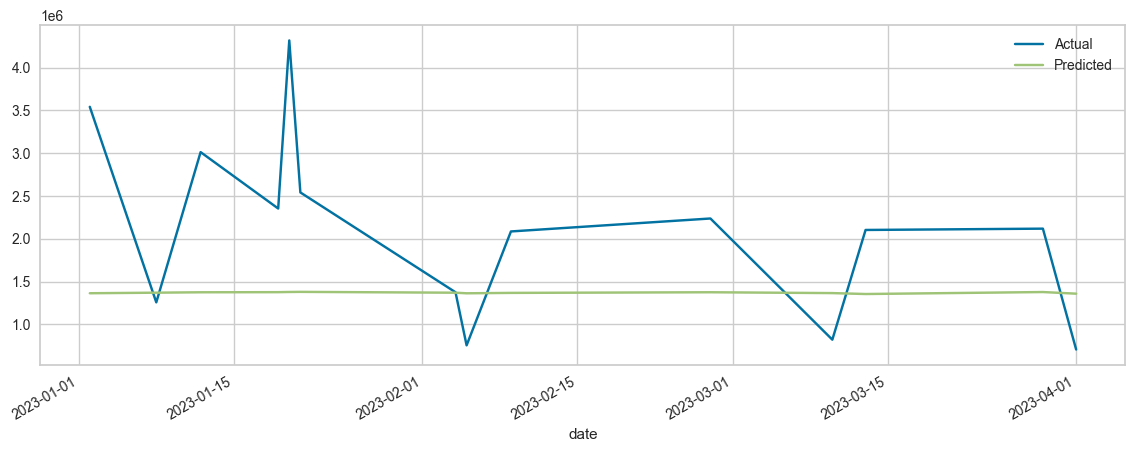

In [44]:
data_test = ts_total_1.loc[(ts_total_1['kode_org'] == 893)&(ts_total_1['kode_des'] == 946)&(ts_total_1.date>='2023-01-01')]
X_test  = data_test[features]
y_test  = data_test[label]

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape((X_test.shape[0], n_steps, n_features))
y_test = y_test.reshape((y_test.shape[0], n_steps, 1))

print('X_test reshaped:',X_test.shape)
print('y_test reshaped:',y_test.shape)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Flatten the actual and predicted values
y_train_actual = y_train.flatten()
y_test_actual = y_test.flatten()
y_train_pred = y_train_pred.flatten()
y_test_pred = y_test_pred.flatten()

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

# Calculate MAE
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)

# Calculate R-squared
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

# Print the results
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Train MAE:', train_mae)
print('Test MAE:', test_mae)
print('Train R-squared:', train_r2)
print('Test R-squared:', test_r2)
df_results = pd.DataFrame({'Actual': y_test_actual, 'Predicted': y_test_pred,'date':data_test.date})
df_results.set_index('date', inplace=True)
df_results.plot(figsize=(14,5))

X_test reshaped: (7, 1, 24)
y_test reshaped: (7, 1, 1)
1/1 [==============================] - 0s 25ms/step
Train RMSE: 955621.9937520926
Test RMSE: 1112922.9667553266
Train MAE: 746589.1450009792
Test MAE: 948549.0
Train R-squared: -0.01684195083474993
Test R-squared: -0.0997028807858018


<Axes: xlabel='date'>

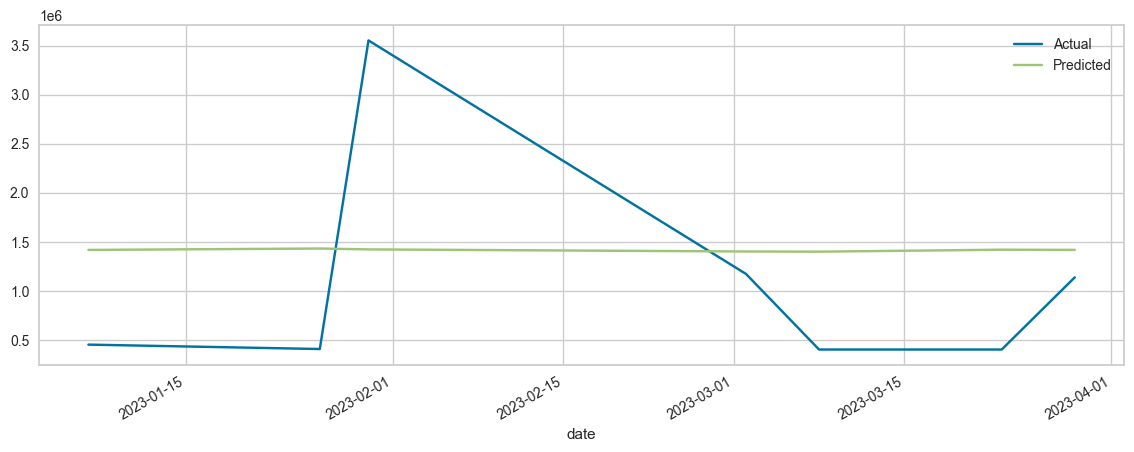

In [45]:
data_test = ts_total_1.loc[(ts_total_1['kode_org'] == 893)&(ts_total_1['kode_des'] == 563)&(ts_total_1.date>='2023-01-01')]
X_test  = data_test[features]
y_test  = data_test[label]

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape((X_test.shape[0], n_steps, n_features))
y_test = y_test.reshape((y_test.shape[0], n_steps, 1))

print('X_test reshaped:',X_test.shape)
print('y_test reshaped:',y_test.shape)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Flatten the actual and predicted values
y_train_actual = y_train.flatten()
y_test_actual = y_test.flatten()
y_train_pred = y_train_pred.flatten()
y_test_pred = y_test_pred.flatten()

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

# Calculate MAE
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)

# Calculate R-squared
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

# Print the results
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Train MAE:', train_mae)
print('Test MAE:', test_mae)
print('Train R-squared:', train_r2)
print('Test R-squared:', test_r2)
df_results = pd.DataFrame({'Actual': y_test_actual, 'Predicted': y_test_pred,'date':data_test.date})
df_results.set_index('date', inplace=True)
df_results.plot(figsize=(14,5))

# PEMBATAS